<a href="https://colab.research.google.com/github/vartikagpt10/EEG-based-ERP-Detection-for-practical-BCI/blob/main/DNN%2BXGBoost%2BSVM%2BPyriemann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and Extract Data

In [ ]:
!pip install --upgrade gdown pyriemann
!gdown https://drive.google.com/uc?id=1RCZlEI1P0NpCqNkjlQMPnTAOU2phFJkq -O /tmp/Data.zip

import zipfile
local_zip = '//tmp/Data.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp/Data')
zip_ref.close()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 7.5MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-cp36-none-any.whl size=9694 sha256=c1cccb2ea072f87dee148158d819e5bbf9bd8d85b17271beedef402d6c07ea30
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4
Downloading...
From: https://drive.google.com/uc?id=1RCZlEI1P0NpCqNkjlQMPnTAOU2phFJkq
To: /tmp/Data.zip
226MB [00:06, 36.4MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from scipy.signal import filtfilt, cheby2

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
train_folder_path = '/tmp/Data/Training set/'
validation_folder_path = '/tmp/Data/Validation set/'

# Data Extraction

In [ ]:
c=0
for i in os.listdir(train_folder_path):
  c+=1
  if c==1:
    temp=sio.loadmat(train_folder_path+i)
    dat=np.squeeze(temp['epo_tr']['x']).tolist()
    dat=np.array(dat)
    lab=np.squeeze(temp['epo_tr']['y']).tolist()
    lab=np.array(lab)[0,:]
    training_data=dat
    training_labels=lab
    continue
  temp=sio.loadmat(train_folder_path+i)
  dat=np.squeeze(temp['epo_tr']['x']).tolist()
  dat=np.array(dat)
  lab=np.squeeze(temp['epo_tr']['y']).tolist()
  lab=np.array(lab)[0,:]
  training_data=np.concatenate((training_data,dat),axis=2)
  training_labels=np.concatenate((training_labels,lab))
training_data=training_data.reshape((2700,56,100))
training_data=training_data[:,:32,:]
print("Training data shape:",training_data.shape)
print("Training labels shape:",training_labels.shape)

Training data shape: (2700, 32, 100)
Training labels shape: (2700,)


In [ ]:
c=0
for i in os.listdir(validation_folder_path):
  c+=1
  if c==1:
    temp=sio.loadmat(validation_folder_path+i)
    dat=np.squeeze(temp['epo_val']['x']).tolist()
    dat=np.array(dat)
    lab=np.squeeze(temp['epo_val']['y']).tolist()
    lab=np.array(lab)[0,:]
    validation_data=dat
    validation_labels=lab
    continue
  temp=sio.loadmat(validation_folder_path+i)
  dat=np.squeeze(temp['epo_val']['x']).tolist()
  dat=np.array(dat)
  lab=np.squeeze(temp['epo_val']['y']).tolist()
  lab=np.array(lab)[0,:]
  validation_data=np.concatenate((validation_data,dat),axis=2)
  validation_labels=np.concatenate((validation_labels,lab))
validation_data=validation_data.reshape((900,56,100))
validation_data=validation_data[:,:32,:]
print("Validation data shape:",validation_data.shape)
print("Validation labels shape:",validation_labels.shape)

Validation data shape: (900, 32, 100)
Validation labels shape: (900,)


In [ ]:
# dat=np.squeeze(temp['epo_val']['y']).tolist()
# dat=np.array(dat)[0,:]
# dat

# Filtering

In [ ]:
def chebyBandpass(signal, lowcut, fs, order):
  nyq=0.5*fs
  low = lowcut/nyq
  # high = highcut / nyq
  b, a = cheby2(order,12, low, btype='low')
  filtered = filtfilt(b, a, signal)
  return filtered

def filterall(data):
  filtered=[]
  for trial in data:
    temp_filtered=[]
    for channel in trial:
      temp_filtered.append(chebyBandpass(channel,20,100,3))
    filtered.append(temp_filtered)
  return np.array(filtered)

filt_train=filterall(training_data)
filt_val=filterall(validation_data)

# Frequecy Domain Visualizations of Pz

## Spectrum function

In [ ]:
def plotSpectrum(signal, fs):
    n=len(signal)
    k=np.arange(n)
    time=n/fs
    frequency_spectra=k/time
    frequency_spectra=frequency_spectra[range(int(n/2))]
    Y=np.fft.fft(signal)/n
    Y=Y[range(int(n/2))]

    plt.subplot(2,1,1)
    plt.plot(k/fs,signal,'b')
    plt.xlabel(' time(s)')
    plt.title('Time domain visualisation')

    plt.subplot(2,1,2)
    plt.plot(frequency_spectra,abs(Y),'r')
    plt.xlabel( 'Freq (Hz) ')
    plt.title('Frequency domain visualisation')

## Unfiltered

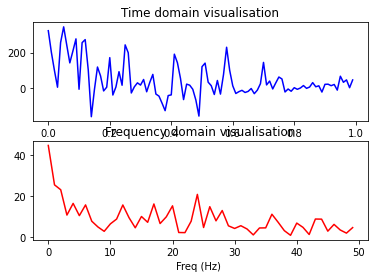

In [ ]:
plotSpectrum(training_data[0,21,:],100)

## Filtered (Low-pass Chebyshev type-II filter with cutoff=20Hz)

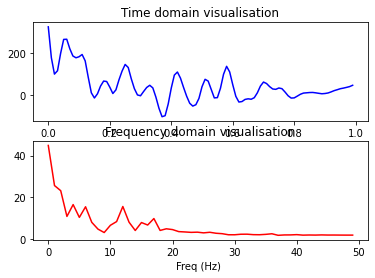

In [ ]:
plotSpectrum(filt_train[0,21,:],100)

# Classification

### Classification Libraries

In [ ]:
from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace

from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import cross_val_score

## Extracting Covariances

In [ ]:
covmat = ERPCovariances(estimator='lwf').fit(filt_train, training_labels)
cov_train = covmat.transform(filt_train)
ts_train = TangentSpace().fit_transform(cov_train)

cov_val = covmat.transform(filt_val)
ts_val = TangentSpace().fit_transform(cov_val)

## SVM

In [ ]:
classifier = svm.SVC()
classifier.fit(ts_train, training_labels)

training_predicted= classifier.predict(ts_train)
validation_pred=classifier.predict(ts_val)

## Results SVM

In [ ]:
print("\n==================== RESULTS ====================")
score = training_predicted==training_labels
print("Training Score:",score.mean())

# score = cross_val_score(classifier, ts_train, training_labels, cv=5)
# print("5-fold Cross Validation Score:",score.mean())

score= validation_pred==validation_labels
print("Validation Score:",score.mean())

print(classification_report(validation_pred,validation_labels))
print("==================================================\n")


==================== RESULTS ====================
Training Score: 0.81
Validation Score: 0.7888888888888889
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       900
           1       0.00      0.00      0.00         0

    accuracy                           0.79       900
   macro avg       0.50      0.39      0.44       900
weighted avg       1.00      0.79      0.88       900




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## XGBoost

In [ ]:
!pip install --upgrade xgboost
from xgboost import XGBClassifier

     |████████████████████████████████| 148.9MB 70kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
model = XGBClassifier()
model.fit(ts_train, training_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
training_predicted= model.predict(ts_train)
validation_pred=model.predict(ts_val)

## Results XGBoost

In [ ]:
print("\n==================== RESULTS ====================")
score = training_predicted==training_labels
print("Training Score:",score.mean())

# score = cross_val_score(classifier, ts_train, training_labels, cv=5)
# print("5-fold Cross Validation Score:",score.mean())

score= validation_pred==validation_labels
print("Validation Score:",score.mean())

print(classification_report(validation_pred,validation_labels))
print("==================================================\n")


==================== RESULTS ====================
Training Score: 1.0
Validation Score: 0.5966666666666667
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       631
           1       0.25      0.18      0.21       269

    accuracy                           0.60       900
   macro avg       0.47      0.48      0.47       900
weighted avg       0.56      0.60      0.57       900




In [ ]:
print(ts_train.shape)
print(training_labels.shape)
print(ts_val.shape)
print(validation_labels.shape)

(2700, 4656)
(2700,)
(900, 4656)
(900,)


##DNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn import feature_selection

In [ ]:
mifs = feature_selection.mutual_info_classif(ts_train, training_labels)

In [ ]:
model = Sequential()
model.add(Dense(8192, activation='relu'))
model.add(Dense(8192, activation='relu'))
model.add(Dense(2048, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(ts_train, training_labels, epochs=100, verbose=1)

In [ ]:
loss, accuracy= model.evaluate(ts_val, validation_labels, verbose=1)

29/29 [==============================] - 0s 5ms/step - loss: 0.5915 - accuracy: 0.7889
